# **Estimando la distribución de una variable aleatoria: el problema de la rana**

El *problema de la rana* dice lo siguiente: supongamos que hay una rana que siempre salta la misma distancia, y cada vez que salta lo hace aleatoriamente en cualquier dirección, entonces ¿cuál es la distribución de probabilidad de la distancia al origen después de $n$ saltos?

Asumimos que la rana salta en un plano, y que "aleatoriamente" quiere decir que la variable aleatoria que modela la dirección de salto sigue una distribución uniforme. Entonces es fácil de ver que la variable aleatoria que define la distancia tras $n$ saltos viene dada por

$$
Y_n=\left|\sum_{k=1}^n e^{i X_k}\right|=\sqrt{n+2\sum_{1\le j< k\le n}\cos (X_j-X_k)}\tag{1}
$$

donde cada $X_k$ es independiente de las otras y todas tienen una distribución uniforme en $[0,2\pi]$. Dos formas de atacar el problema: a través de una aproximación analítica o con una simulación con números pseudo-aleatorios.

## 1. Aproximación analítica

Para $n=0$ y $n=1$ es fácil dar una función de densidad explícita, ya que son casos triviales. Para $n=2$ podemos usar $\rm (1)$ y hallar que

$$
f_{Y_2}(c)=\frac1{\pi \sqrt{1-c^2/4}}\, \mathbf{1}_{[0,2]}(c)\tag2
$$

donde $\mathbf 1_{A}$ es la función indicatriz del conjunto $A$.

Sin embargo a partir de $n\ge 3$ no es claro cómo calcular explícitamente la función de densidad de $Y_n$, suponiendo que fuese posible hacerlo, así que en principio nos tendríamos que contentar con una aproximación. Para esto podemos utilizar el [teorema del límite central para vectores aleatorios](https://en.wikipedia.org/wiki/Central_limit_theorem#Multidimensional_CLT) (TLC de ahora en adelante), ya que $V_k:=(\cos(X_j),\sin(X_j))\equiv e^{ i X_j}$. Entonces si la varianza de cada componente de $V_k$ es finita y $E[V_k]$ es finita (que en nuestro caso es cero) tenemos que

$$
\frac1{\sqrt n}\left(\sum_{k=1}^n V_k-E[V_k]\right)\overset{\text{distribución}}{\longrightarrow}N_2,\quad\text{ cuando }n\to\infty\tag{3}
$$

donde $N_2$ es una variable aleatoria con [distribución bi-normal](https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Density_function) de media cero y matriz de covarianza igual a la de cada $V_k$. Y por tanto

$$
\begin{align*}
\lim_{n\to\infty}\Pr\left[\frac{Y_n}{\sqrt n}\le d\right]&=\lim_{n\to\infty}\Pr\left[\frac{\sum_{k=1}^n V_k}{\sqrt n}\in d\overline{\Bbb D}\right]\\
&=\int_{d\Bbb D} f_{N_2}(x,y)\, d(x,y)\\
&=\frac1{\pi}\int_{d\Bbb D} e^{-(x^2+y^2)}d(x,y)\\
&=\frac1{\pi}\int_0^{2\pi}\int_0^d r e^{-r^2}dr\, d\theta\\
&=1-e^{-d^2}
\end{align*}\tag{4}
$$

donde $\Bbb D$ es el disco de radio uno en $\Bbb R^2$, y donde hemos usado el hecho de que la matriz de covarianza de los $V_k$ es $\begin{bmatrix}1/2 & 0\\ 0& 1/2\end{bmatrix}$.

Entonces, después de un simple cambio de variable, $\rm (4)$ nos deja finalmente la aproximación $F_{Y_n}(x)\approx 1-e^{-x^2/n}$ para $n$ suficientemente grande. Como dato adicional decir que, si lo necesitásemos, sería posible estimar el error de esta aproximación a través de la [desigualdad de Berry Esseen](https://en.wikipedia.org/wiki/Berry%E2%80%93Esseen_theorem).

## 2. Muestra simulada y posterior estimación

Haremos una simulación con el lenguaje de programación Julia y las librerías [`KernelDensity`](https://github.com/JuliaStats/KernelDensity.jl), [`StatsBase`](https://github.com/JuliaStats/StatsBase.jl), y [`Plots`](https://github.com/JuliaPlots/Plots.jl/).

### 2.1 Listas pseudo-aleatorias y muestra simulada

En cada sesión de Julia la primera vez que llamamos a la función `rand()` ésta nos devuelve un número entre cero y uno de una larga lista, y la próxima vez que volvamos a llamarla nos dará el siguiente número en la lista. Esta lista, generada por un algoritmo, tiene propiedades semejantes a las de una verdadera lista de números aleatorios con distribución uniforme en $[0,1)$. A los algoritmos que generan estas listas se les denomina *generadores de números pseudo-aleatorios* (o también llamados generadores de números aleatorios sin más, ya que se sobreentiende en el contexto que no son verdaderos números aleatorios). Hay mucha bibliografía sobre estos algoritmos, donde se analizan sus propiedades estadísticas y su idoneidad a la hora de simular aleatoriedad para un experimento dado. En nuestro caso el generador de números (pseudo) aleatorios que utiliza Julia por defecto es excelente y con él podremos hacer una buena simulación.

Lo que vamos a hacer a continuación es crear una muestra simulada suficientemente grande de la variable aleatoria $Y_n$ que vayamos a estudiar. Empezamos por definir una función `rd`, que al llamarla con `rd(n)` devuelve un valor que simula la distancia después de saltar aleatoriamente $n$ veces

In [1]:
function rd(n::Int)
    p = 1.0 # el primer salto
    for j in 2:n
        p += exp(2pi * im * rand())
    end
    return abs(p)
end;

A partir de la función anterior generamos un vector que contenga un número suficientemente grande de experimentos aleatorios (nuestra muestra simulada), y lo haremos con la siguiente función

In [2]:
function sim(n::Int, m::Int = 22)
    datos = zeros(2^m) # vector cero de longitud 2^m
    for i in 1:2^m
        datos[i] = rd(n) # llenamos el vector con distancias aleatorias simuladas
    end
    return datos
end;

La función anterior se ejecuta como `sim(n)` o como `sim(n,m)`, donde `n` representa el número de saltos y `m` es un parámetro opcional que define el número de experimentos aleatorios a realizar, es decir el tamaño de la muestra (por defecto el número de experimentos a realizar es $2^{22}\approx 4\cdot 10^6$).

### 2.2 Método KDE de estimación de la densidad de una muestra

La librería `KernelDensity` realiza una estimación no-paramétrica de la densidad en cada punto, denominada en la literatura como KDE ([kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation)), que en el caso de una variable aleatoria con valores en $\Bbb R$ toma la forma

$$
\widehat f(x;h)=\frac1{N h}\sum_{k=1}^N K\left(\frac{x-x_k}{h}\right)\tag{5}
$$

donde $h$ se denomina *ancho de banda* y es un parámetro que depende de la muestra, y es de suma importancia para la correcta estimación de la función de densidad; $N$ es el tamaño de la muestra (en nuestro programa tendríamos que $N=2^m$); y $x_k$ es un elemento de la muestra (en nuestro programa cada coordenada del vector `sim(n,m)`). 

Por último $K$ es una función de densidad simétrica, de media nula y varianza finita, denominada el núcleo o *kernel* de la estimación, cuya función es asignar un valor relativo a cada punto $x_k$ para la estimación de la densidad en $x$. Es común elegir para $K$ el [núcleo gaussiano](https://en.wikipedia.org/wiki/Gaussian_function).

### 2.3 Distribución empírica

También podemos utilizar otro método de aproximación que consiste en hallar lo que se conoce como *distribución empírica* de una muestra dada. La distribución empírica de una muestra $M$ se define como

$$
\widehat F(t):=\frac{\#\{x\in M: x\le t\}}{\# M}\tag{6}
$$

donde $\# A$ representa la cardinalidad del conjunto $A$. La distribución empírica aproxima a la verdadera distribución subyacente a la muestra. Además podríamos estimar cómo de buena es tal aproximación utilizando [la desigualdad de Dvoretzky–Kiefer–Wolfowitz](https://en.wikipedia.org/wiki/Dvoretzky–Kiefer–Wolfowitz_inequality).

La librería `StatsBase` tiene una función para hallar la distribución empírica que utilizaremos más adelante.

## 3. Graficación

La graficación corre a cargo fundamentalmente de la librería `Plots`. El siguiente código define una función que grafica funciones de densidad y permite comparar las estimaciones por el método KDE y el TLC.

El núcleo por defecto que utiliza la librería `KernelDensity` para estimar la densidad es el gaussiano, y un valor apropiado de ancho de banda para la muestra dada es definido por un algoritmo.

In [3]:
using KernelDensity, Plots
function p1(n::Int, m::Int= 22; c::Symbol = :auto)
    r = 0:n/100:n # dominio
    k = kde(sim(n,m)) # PDF estimada del vector sim(n,m) por el método KDE
    x = pdf(k,r) # imagen de la densidad en cada punto del dominio
    p = plot!(r, x, color = c,
        xlabel = "Distancia",
        label = "PDF de $n saltos estimada por KDE")
    f(y) = 2y*exp(-y^2/n)/n # PDF aproximada con el TLC
    p = plot!(f, 0, n, l = :dash, w = 3, color = c,
        label = "PDF de $n saltos estimada por el TLC")
return p
end;

Cada vez que llamamos a la función `p1` ésta añade una gráfica más sobre el mismo lienzo, los parámetros `m` y `c` son opcionales, el primero (al igual que antes) controla la cantidad de experimentos sobre la que hacer las estimaciones, y el segundo [la paleta de colores a usar](https://docs.juliaplots.org/latest/colors/). Un ejemplo

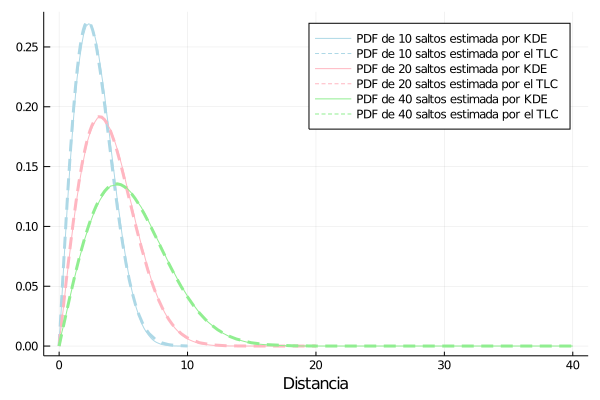

In [4]:
p1(10, c=:blues); p1(20, c=:reds); p1(40, c=:greens)

Ahora definiremos una función parecida para comparar las distribuciones usando además de los dos métodos anteriores también la distribución empírica

In [5]:
using StatsBase
function p2(n::Int, m::Int= 22; c::Symbol = :auto)
    r = 0:n/100:n
    k = kde(sim(n,m))
    de = ecdf(sim(n,m))
    x = pdf(k,r)
    cdfx = cumsum(x)/sum(x)
    p = plot!(r, cdfx, color = c,
            xlabel = "Distancia",
            ylabel = "Probabilidad ",
            label = "CDF de $n saltos estimada por KDE")
    g(y) = 1- exp(-y^2/n)
    p = plot!(g, 0, n, l = :dash, w = 3, color = c,
        label = "CDF de $n saltos estimada por el TLC")
    p = plot!(r, de(r), l = :dot, color = c, w = 2,
        label = "CDF empírica de la muestra para $n saltos",
        legend = :bottomright)
return p
end;

La función `p2` es similar a `p1`: cada vez que es llamada dibuja sobre el lienzo que esté siendo usado en ese momento. Un ejemplo

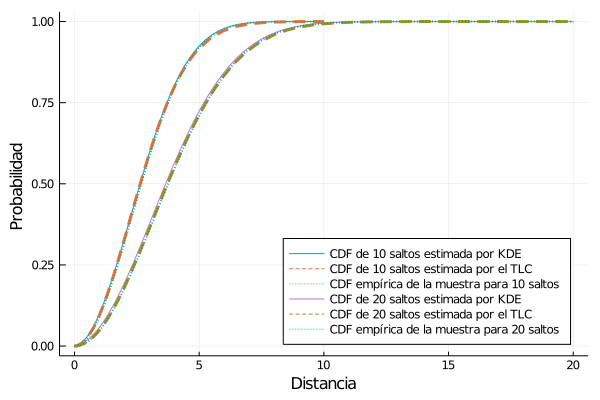

In [6]:
plot(); # Reseteamos el lienzo para empezar a graficar en uno nuevo
p2(10); p2(20)